<a href="https://colab.research.google.com/github/daggermaster3000/CZBIO-Interview/blob/main/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

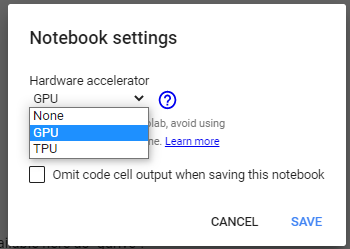

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


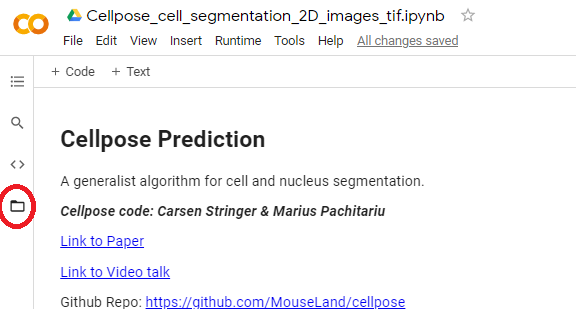

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

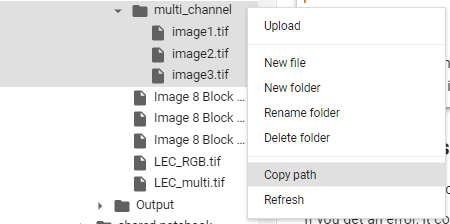

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [1]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-v9yddvvb
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-v9yddvvb
  Resolved https://www.github.com/mouseland/cellpose.git to commit d95f58a6676362d4e625076e55cd73b47c3bae26
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.7 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.7.dev14+gd95f58a66-py3-none-any.whl size=212496 sha256=1b56e38574d3cbd4ea8e7014debe435a28ccab904bf7bad1d4e428ad4519fb94
  Stored in directory: /tmp/pip-ephem-wheel-cache-g53ex38p/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


In [2]:
!pip install iohub tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 19.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=1df4cf62863e641db3c9c893bce2136264382282c83efd57062fec12d17a0843
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2025.8.28
    Uninstalling tifffile-2025.8.28:
      Successfully uninstalled tifffile-2025.8.28


Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-09-16 09:55:10,355 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-09-16 09:55:10,356 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	linux 
python version: 	3.12.11 
torch version:  	2.8.0+cu126
2025-09-16 09:55:10,597 [INFO] ** TORCH CUDA version installed and working. **
2025-09-16 09:55:10,598 [INFO] ** TORCH CUDA version installed and working. **
2025-09-16 09:55:10,599 [INFO] >>>> using GPU (CUDA)
2025-09-16 09:55:13,168 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:05<00:00, 216MB/s]


Input directory with your images:

In [6]:
import numpy as np
from iohub import open_ome_zarr


# Open OME-Zarr
with open_ome_zarr("/content/drive/MyDrive/take_home_dataset_1.zarr", mode="r", layout="auto") as dataset:

    img_array = dataset["0"]  # first position
    raw_data = img_array.numpy()  # TCZYX

    # Extract: first timepoint, first channel -> ZYX
    timepoint, channel = 0, 0
    vol = raw_data[timepoint, channel][:, None, :, :]   # shape (Z, Y, X)
    print("Volume shape:", vol.shape)

# Load into memory as a numpy array
print("Loaded volume:", vol.shape, vol.dtype)


Volume shape: (78, 1, 1500, 1600)
Loaded volume: (78, 1, 1500, 1600) uint32


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [6]:
img = vol[50, :, :, None]

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (1500, 1600, 1). Assuming channel dimension is last with 1 channels


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [8]:
first_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

In [ ]:
from tqdm import tqdm
# Run slice-by-slice with progress bar
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0
masks_all = []
for z in tqdm(range(vol.shape[0]), desc="Cellpose Z-slices"):
    mask, flows, styles = model.eval(
        vol[z],
        batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize}
    )
    masks_all.append(mask)

# Stack masks back into 3D
masks = np.stack(masks_all, axis=0)
print("Mask stack shape:", masks.shape)
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, vol[50], masks[50], flows[0])
plt.tight_layout()
plt.show()

Cellpose Z-slices:  60%|██████    | 47/78 [17:47<11:35, 22.43s/it]

2025-09-16 10:02:35,299 [INFO] ** TORCH CUDA version installed and working. **
GPU available: True
Available keys: ['0']
Zarr shape (TCZYX): (10, 1, 78, 1500, 1600)
Sub-volume shape: (78, 1500, 1600)
Loaded into memory: (78, 1500, 1600) float32
2025-09-16 10:02:39,992 [INFO] running YX: 78 planes of size (1500, 1600)
2025-09-16 10:03:56,482 [INFO] 100%|##########| 39/39 [01:16<00:00,  1.96s/it]
2025-09-16 10:04:00,509 [INFO] running ZY: 1500 planes of size (78, 1600)
2025-09-16 10:06:59,799 [INFO] 100%|##########| 94/94 [02:59<00:00,  1.91s/it]
2025-09-16 10:07:01,400 [INFO] running ZX: 1600 planes of size (78, 1500)
2025-09-16 10:10:18,981 [INFO] 100%|##########| 100/100 [03:17<00:00,  1.98s/it]
2025-09-16 10:10:26,303 [INFO] network run in 466.31s
2025-09-16 10:10:43,318 [INFO] masks created in 10.23s
Masks shape: (78, 1500, 1600)


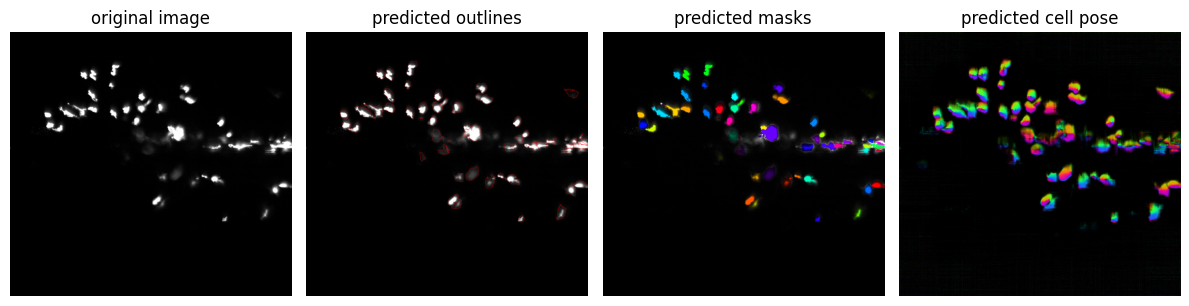

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zarr
from cellpose import models, plot, core

# --------------------------------------------
# Check GPU availability
# --------------------------------------------
use_gpu = core.use_gpu()
print("GPU available:", use_gpu)

# --------------------------------------------
# Open Zarr directly (lazy)
# --------------------------------------------
zarr_path = Path("/content/drive/MyDrive/take_home_dataset_1.zarr")
store = zarr.open(zarr_path, mode="r")

print("Available keys:", list(store.array_keys()))
# e.g. "0" for first position

# Load lazily, don’t read full array
raw_data = store["0"]   # this is a zarr.Array, shape (T, C, Z, Y, X)
print("Zarr shape (TCZYX):", raw_data.shape)

# --------------------------------------------
# Extract only first timepoint + channel
# (Z,Y,X). Still lazy, only reads when indexed
# --------------------------------------------
timepoint, channel = 0, 0
vol = raw_data[timepoint, channel]   # Z,Y,X (zarr.Array, not yet in RAM)
print("Sub-volume shape:", vol.shape)

# Optionally: downsample or crop here before computing
# vol = vol[::2, ::2, ::2]

# Convert only this subset into RAM (float32)
vol = np.array(vol, dtype=np.float32)
print("Loaded into memory:", vol.shape, vol.dtype)


# Segmentation thresholds
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

# --------------------------------------------
# Run 3D segmentation with tiling
# --------------------------------------------
masks, flows, styles = model.eval(
    vol,
    batch_size=128,
    flow_threshold=flow_threshold,
    cellprob_threshold=cellprob_threshold,
    z_axis=0,                   # 0 = Z axis
    channel_axis=None,          # no channel axis
    do_3D=True,
    normalize={"tile_norm_blocksize": tile_norm_blocksize},

)

print("Masks shape:", masks.shape)

# --------------------------------------------
# Visualization (middle Z slice)
# --------------------------------------------
z_mid = masks.shape[0] // 2
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, vol[z_mid], masks[z_mid], flows[0][z_mid])
plt.tight_layout()
plt.show()
